In [107]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint ,  solve_ivp, quad
from scipy import optimize
from IPython.display import display, Latex


In [222]:
def V1(phi,r):
    v=phi*(phi+2*r)/(1+(r+phi)**2)
    return v

def V0(phi,r):
    v=phi-(r**2+1)*np.arctan(r+phi)
    return v

def V2(phi,r):
    v=2*(phi+r)*(1+r**2)/(1+(r+phi)**2)**2
    return v

def ret_root(r,E):
    E_min=-(r**2+1)*np.arctan(r)
    E_max=(r**2+1)*np.arctan(r)-2*r
    Error_msg="Bro! pick the energy between the max {2}  and min {3},got :{0} for r:{1} ".format(E,r,E_max,E_min)
    assert E<E_max and E>E_min, Error_msg
    root=[]
    i=0
    while len(root)<2 and i<100:
        x0=(2*np.random.rand()-1)*2*r
        x = np.round(optimize.newton(lambda x,r : V0(x,r)-E, x0, fprime=V1,fprime2=V2,args=(r,)),4)
        if x>-2*r and x not in root:
            root.append(x)
        i+=1
    root=np.sort(root)
    return root

def calc_T(V0,r,E):
    roots=ret_root(r,E)
    if len(roots)==1:
        print("roots not found properply")
        return
#     print(roots)
    th=1e-4
    N=1000
    x=np.linspace(roots[0],roots[1],N)[1:-1]
    y=(2*(E-V0(x,r)))**-0.5
#     d=np.trapz(y,x)
    d=quad(lambda x,r,E : (-2*(V0(x,r)-E))**-0.5,roots[0]+th,roots[1]-th,args=(r,E))[0]

    return d

def damp_coeff(t,T,A,r=1):
    #x=-2*r
    x=0
    psi=x+A*np.cos(2*np.pi*t/T)
    y=((1+r**2)*(r+psi)/(1+(r+psi)**2)**3)
    return y/T

def amplification_info(eta,ohm):
    eta_max=3**(1.5)/(ohm*8)
    display(Latex("$\eta_{max}=$"+str(eta_max)))
    f=lambda r: eta*ohm*(1+r**2)**2-2*r
    if eta>=eta_max:
        print("amplification not possible")
        return

    root=[]
    i=0
    while len(root)<2 and i<10:
        x0=(2*np.random.rand()-1)*1e-1+3**-0.5
        x = np.round(optimize.newton(f, x0, fprime=lambda r : eta*ohm*4*r*(1+r**2)-2),4)
        if x not in root:
            root.append(x)
        i+=1
    
    if len(root)==1: 
        print("only one root found so trying bisection method")
        root=[]
        
        root.append(optimize.bisect(f,0,3**-0.5))
        right=10
        while np.sign(f(right))==-1:
            right+=10
        root.append(optimize.bisect(f,3**-0.5,right))
        
    root=np.sort(root)
    return root


In [230]:
r=0.7
phi_0=1e-3
E=phi_0-(r**2+1)*np.arctan(r+phi_0)

2*np.pi/calc_T(V0,r,E)

2.7191420166799882

/var/folders/98/5wcykpls4kd1dcm4775b11cj50qjlt/T/ipykernel_1919/75712497.py:38: RuntimeWarning: invalid value encountered in power
  y=(2*(E-V0(x,r)))**-0.5


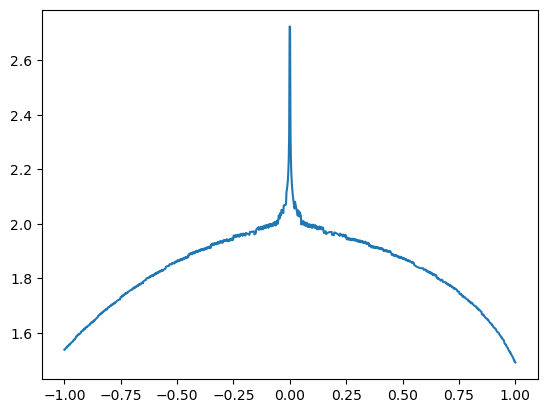

In [235]:
r=0.7
T=[]
phi_list=np.linspace(-1,1,1000)
# E_list=np.linspace(-(r**2+1)*np.arctan(r),(r**2+1)*np.arctan(r)-2*r,100)[1:-1]
E_list=phi_list-(r**2+1)*np.arctan(r+phi_list)
for E in E_list:    
    T.append(calc_T(V0,r,E))
#print(T)
plt.plot(phi_list,2*np.pi/np.array(T))
plt.show()

In [236]:
r=0.7

lin_f=(2*r/(1+r**2))**0.5
print("linear frequency",lin_f)
phi_0=1e-1
E=phi_0-(r**2+1)*np.arctan(r+phi_0)
del_E=phi_0-(r**2+1)*np.arctan(r+phi_0)+(r**2+1)*np.arctan(r)
x_e=(del_E*(1+r**2)/r)**0.5
T=np.pi*((1+r**2)/(2*r))**0.5
print(E,del_E,x_e,T,2*np.pi/T)
calc_T(V0,r,E)

linear frequency 0.9693282805305133
-0.9053640039130934 0.004617683026827413 0.09914165702218247 3.2409996867835114 1.9386565610610265


3.146765225998836

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.21978973 1.20683863]
gamma_0= -0.05765055628124857


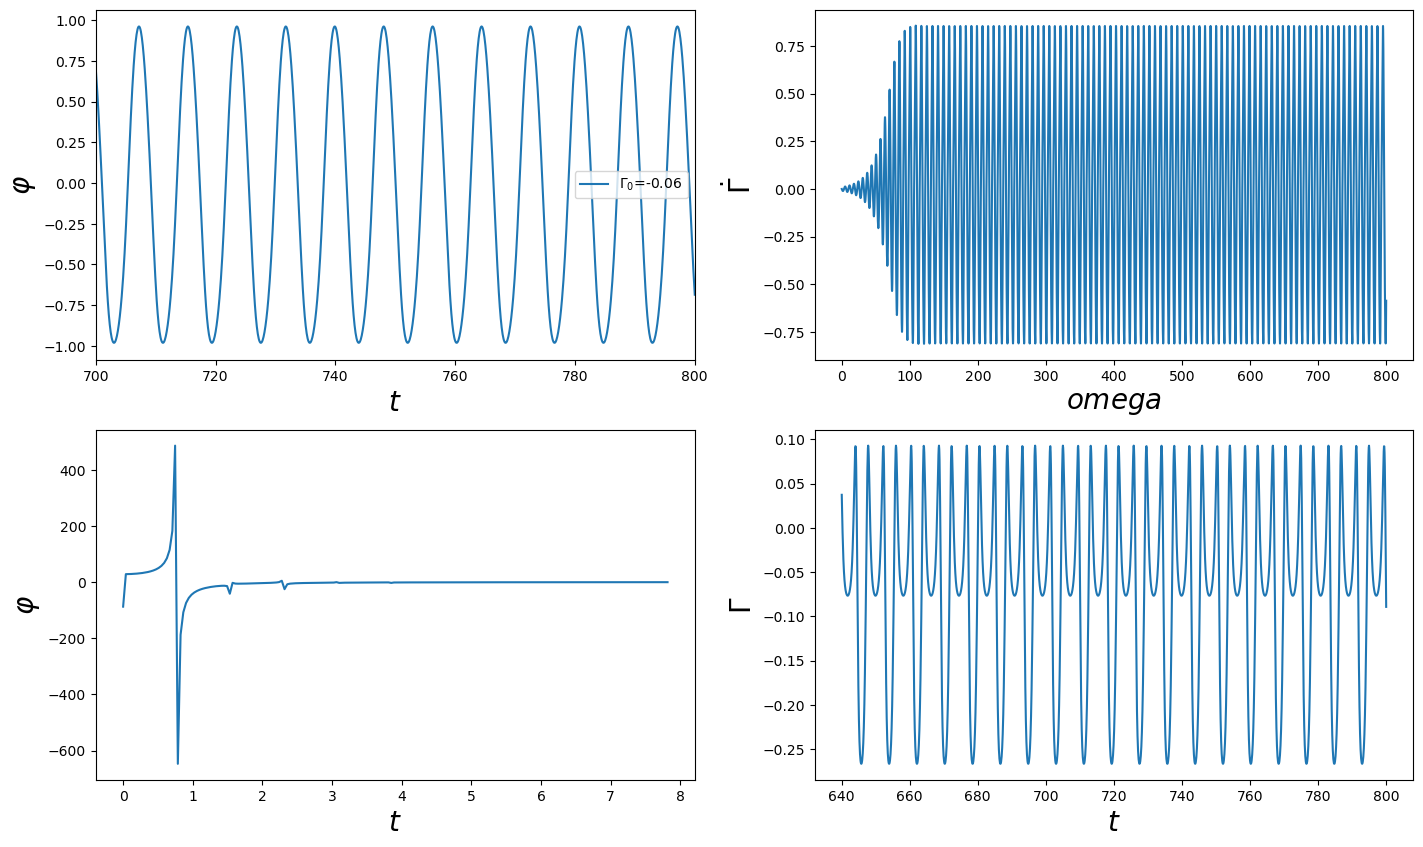

non-linear frequency= 2.1224716331258455
linear frequency= 1.9386565610610267
observed frequency= 0.7853981633974483


In [238]:
eta=0.1
ohm=4e0
r=0.7
r_range=amplification_info(eta,ohm)
print("r_range=",r_range)
if r<r_range[0] or r>r_range[1]:
    print("r out of range, select r to be in amplification regime")
gamma_0=eta-2*r/(ohm*(1+r**2)**2)
print("gamma_0=",gamma_0)
   
tf=8e2              ### DO NOT increase this by a lot
N_step=1000*10
f_range=[int(0.8*N_step),N_step]

phi_0,phi_d_0=1e-2,0
#E0=phi_0*(phi_0+2*r)/(1+(r+phi_0)**2)
#print(E0)
psi_0=np.array([phi_0,phi_d_0])
param_list=[ohm,r,eta,1] 
zz,t=evolve(psi_0,tf,param_list,N_step)
fig, axs = plt.subplots(2, 2,figsize=(17,10))

axs[0,0].plot(t,zz[0],label="$\Gamma_0$={0}".format(np.round(gamma_0,2)))
# axs[0,0].set_ylim([-1e-3,1e-3])
axs[0,0].set_ylabel("$\\varphi$",fontsize=20)
axs[0,0].set_xlabel('$t$',fontsize=20)
axs[0,0].set_xlim([700,800])
axs[0,0].legend(loc='best')
# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

# axs[0,1].plot(t,-(eta-(2*(1+r**2)*(r+zz))/(ohm*(1+(r+zz)**2)**3)))

axs[0,1].plot(t,zz[1])
axs[0,1].set_ylabel("$\dot{\Gamma}$",fontsize=20)
axs[0,1].set_xlabel('$omega$',fontsize=20)

# param_list=[ohm,r,eta,0] 
# zz1,t=evolve(psi_0,tf,param_list,N_step)

# axs[1,0].plot(t,zz[0])
# f_range=[t*N_step,N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
omega_list=2*np.pi*np.arange((f_range[1]-f_range[0])//10)/(t_range[1]-t_range[0])
zz_f=np.fft.fft(zz[0][f_range[0]:f_range[1]])[:(f_range[1]-f_range[0])//10]

axs[1,0].plot(omega_list,zz_f)
# axs[1,0].set_xlim([100,200])
#axs[1,0].set_xlim([0,100])

axs[1,0].set_ylabel("$\\varphi$",fontsize=20)
axs[1,0].set_xlabel('$t$',fontsize=20)

# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)
gamma_term=-(eta-(2*(1+r**2)*(r+zz[0]))/(ohm*(1+(r+zz[0])**2)**3))
axs[1,1].plot(t[f_range[0]:f_range[1]],gamma_term[f_range[0]:f_range[1]])
axs[1,1].set_ylabel("$\Gamma$",fontsize=20)
axs[1,1].set_xlabel('$t$',fontsize=20)

plt.show() 
E=phi_0-(r**2+1)*np.arctan(r+phi_0)
print("non-linear frequency=",2*np.pi/calc_T(V0,r,E))
print("linear frequency=",2*(2*r/(1+r**2))**0.5)
print("observed frequency=",omega_list[np.argmax(np.abs(zz_f))])

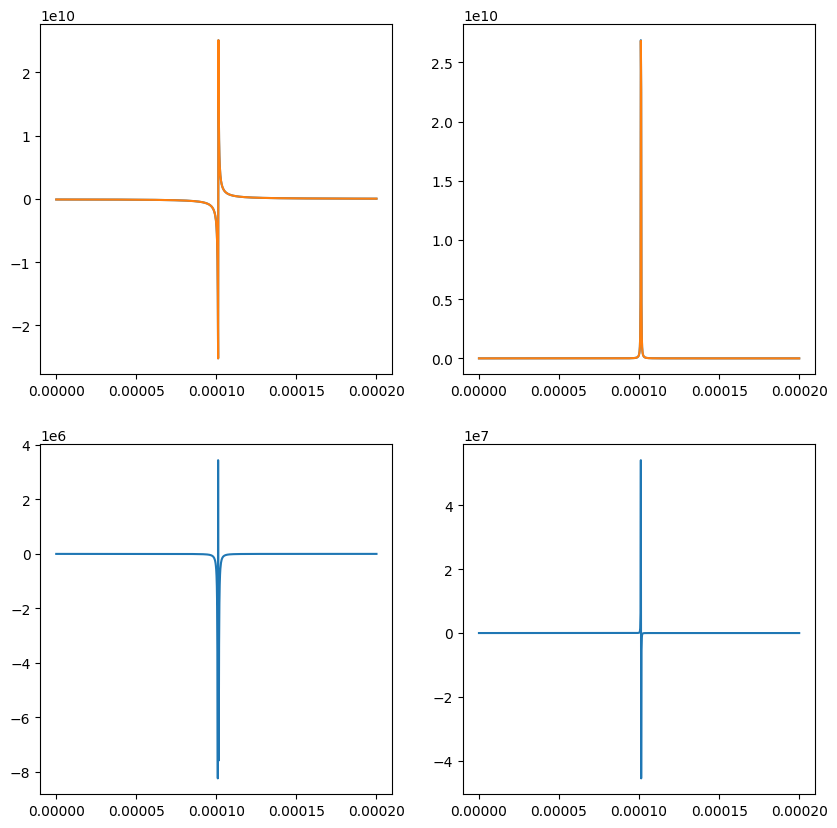

In [15]:
omega_0=2e-4
N=1000
omega=omega_0*np.linspace(0,1,N)
xi=1/(omega**2-2*1j*beta*omega-v**2+v**2*(4*Q*k-1-1j*omega-k**2)/((omega-1j)**2-k**2))

Im_sigma=8*v**2*omega*(Q*k/(k**2+1)**2)
Re_sigma=-v**2*4*Q*k/(1+k**2)
xi_r=1/(omega**2-2*1j*beta*omega-v**2+Re_sigma+1j*Im_sigma)

fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0,0].plot(omega,np.real(xi))
axs[0,0].plot(omega,np.real(xi_r))
axs[0,1].plot(omega,np.imag(xi))
axs[0,1].plot(omega,np.imag(xi_r))
axs[1,0].plot(omega,np.real(xi-xi_r))
axs[1,1].plot(omega,np.imag(xi-xi_r))
plt.show()

In [2]:
k=2
Q=1.6*10**5
nu=2e-7
beta=1e-7

def ODE(t,z,beta,nu,Q,k):
    #d=3.2*10**5
    d=1e0
    u,v,xeta,eta=z
    v_dot=nu**2*(2*xeta+xeta**2+eta**2)*d**2/(1+u)-nu**2*u*d**2/(1+u)-2*beta*v*d
    u_dot=v
    xeta_dot=(-(1-(1+u)**0.5)/(1+u)-xeta-k*eta-2*Q*u*eta/(1+u))*d
    eta_dot=(k*(1-(1+u)**0.5)/(1+u)-eta+k*xeta+2*Q*u*(1+xeta)/(1+u))*d

    x_list=[u_dot,v_dot,xeta_dot,eta_dot]
    return x_list
    
def evolve(psi_0,tf,param_list,N_step=100):
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(ODE, [0,tf],psi_0,args=param_list,dense_output=True, t_eval=t)
    zz=xx.sol(t)
    sol=[]
    sol.append((zz[0]))
    sol.append((zz[1]))
    sol.append((zz[2]))
    sol.append((zz[3]))

    return sol,t
    

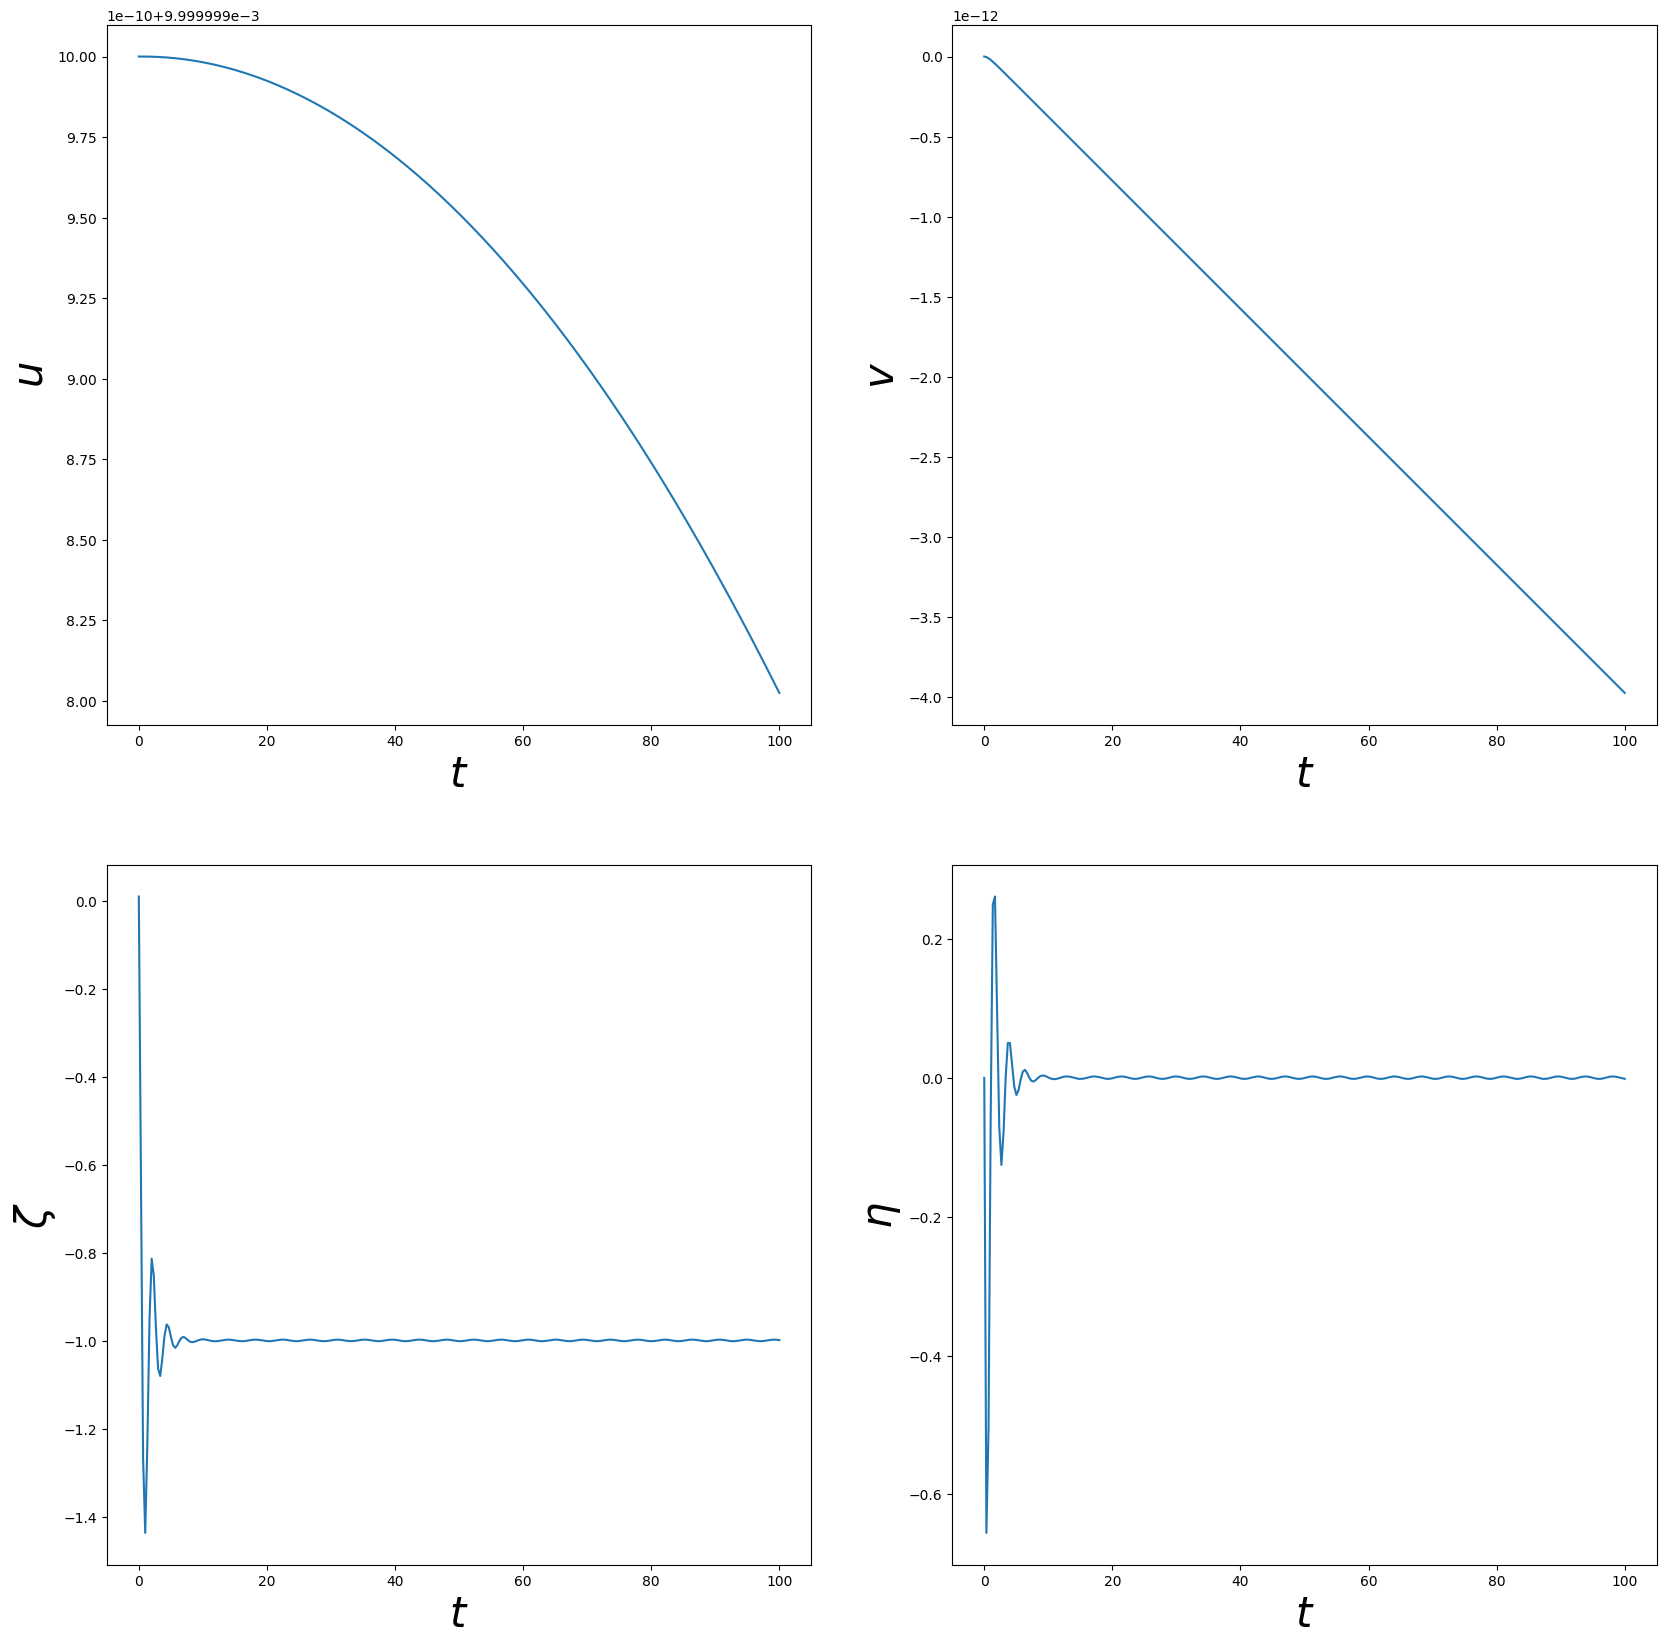

In [25]:
param_list=[beta,nu,Q,k]    
tf=1e2               ### DO NOT increase this by a lot
u_0,v_0,xeta_0,eta_0=1e-2,0,1e-2,0
psi_0=np.array([u_0,v_0,xeta_0,eta_0])
label_list=["$u$","$v$","$\\zeta$","$\\eta$"]

N_step=300
fig, axs = plt.subplots(2, 2,figsize=(20,20))
zz,t=evolve(psi_0,tf,param_list,N_step)
  
for i in range(4):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$t$',fontsize=30)

plt.show() 

In [16]:
lambda_L=1.55*1e-6
F=1e4
xi=np.pi*lambda_L/(2*F)
gamma_m=1e3
g=9.8
eta=(gamma_m/2)*(xi/g)**0.5
eta

0.002492199210420105

In [3]:
w_L=1e9
beta_eq=1e-5
r=1
eta=2e-3

k=2
Q=1.6*10**5
nu=2e-7
beta=1e-7

def ODE(t,z,w_L,beta_eq,r,eta):
    ohm=w_L*beta_eq
    u,v,w,y=z
    #v_dot=nu**2*(2*xeta+xeta**2+eta**2)-nu**2*u-2*beta*v
    v_dot=beta_eq*(2*w+w**2+y**2)-2*beta_eq*u-2*eta*v
    u_dot=v
    #xeta_dot=-(1-(1+u)**0.5)/(1+u)-xeta-k*eta-2*Q*u*eta/(1+u)
    w_dot=0.5*ohm*u-ohm*w-w_L*(beta_eq*r+u)*y
    #eta_dot=k*(1-(1+u)**0.5)/(1+u)-eta+k*xeta+2*Q*u*(1+xeta)/(1+u)
    y_dot=-0.5*r*ohm*u-ohm*y+ohm*(beta_eq*r+u)*w
    x_list=[u_dot,v_dot,w_dot,y_dot]
    return x_list
    
def evolve(psi_0,tf,param_list,N_step=100):
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(ODE, [0,tf],psi_0,args=param_list,dense_output=True, t_eval=t,method="RK23")
    zz=xx.sol(t)
    sol=[]
    sol.append((zz[0]))
    sol.append((zz[1]))
    sol.append((zz[2]))
    sol.append((zz[3]))
    return sol,t

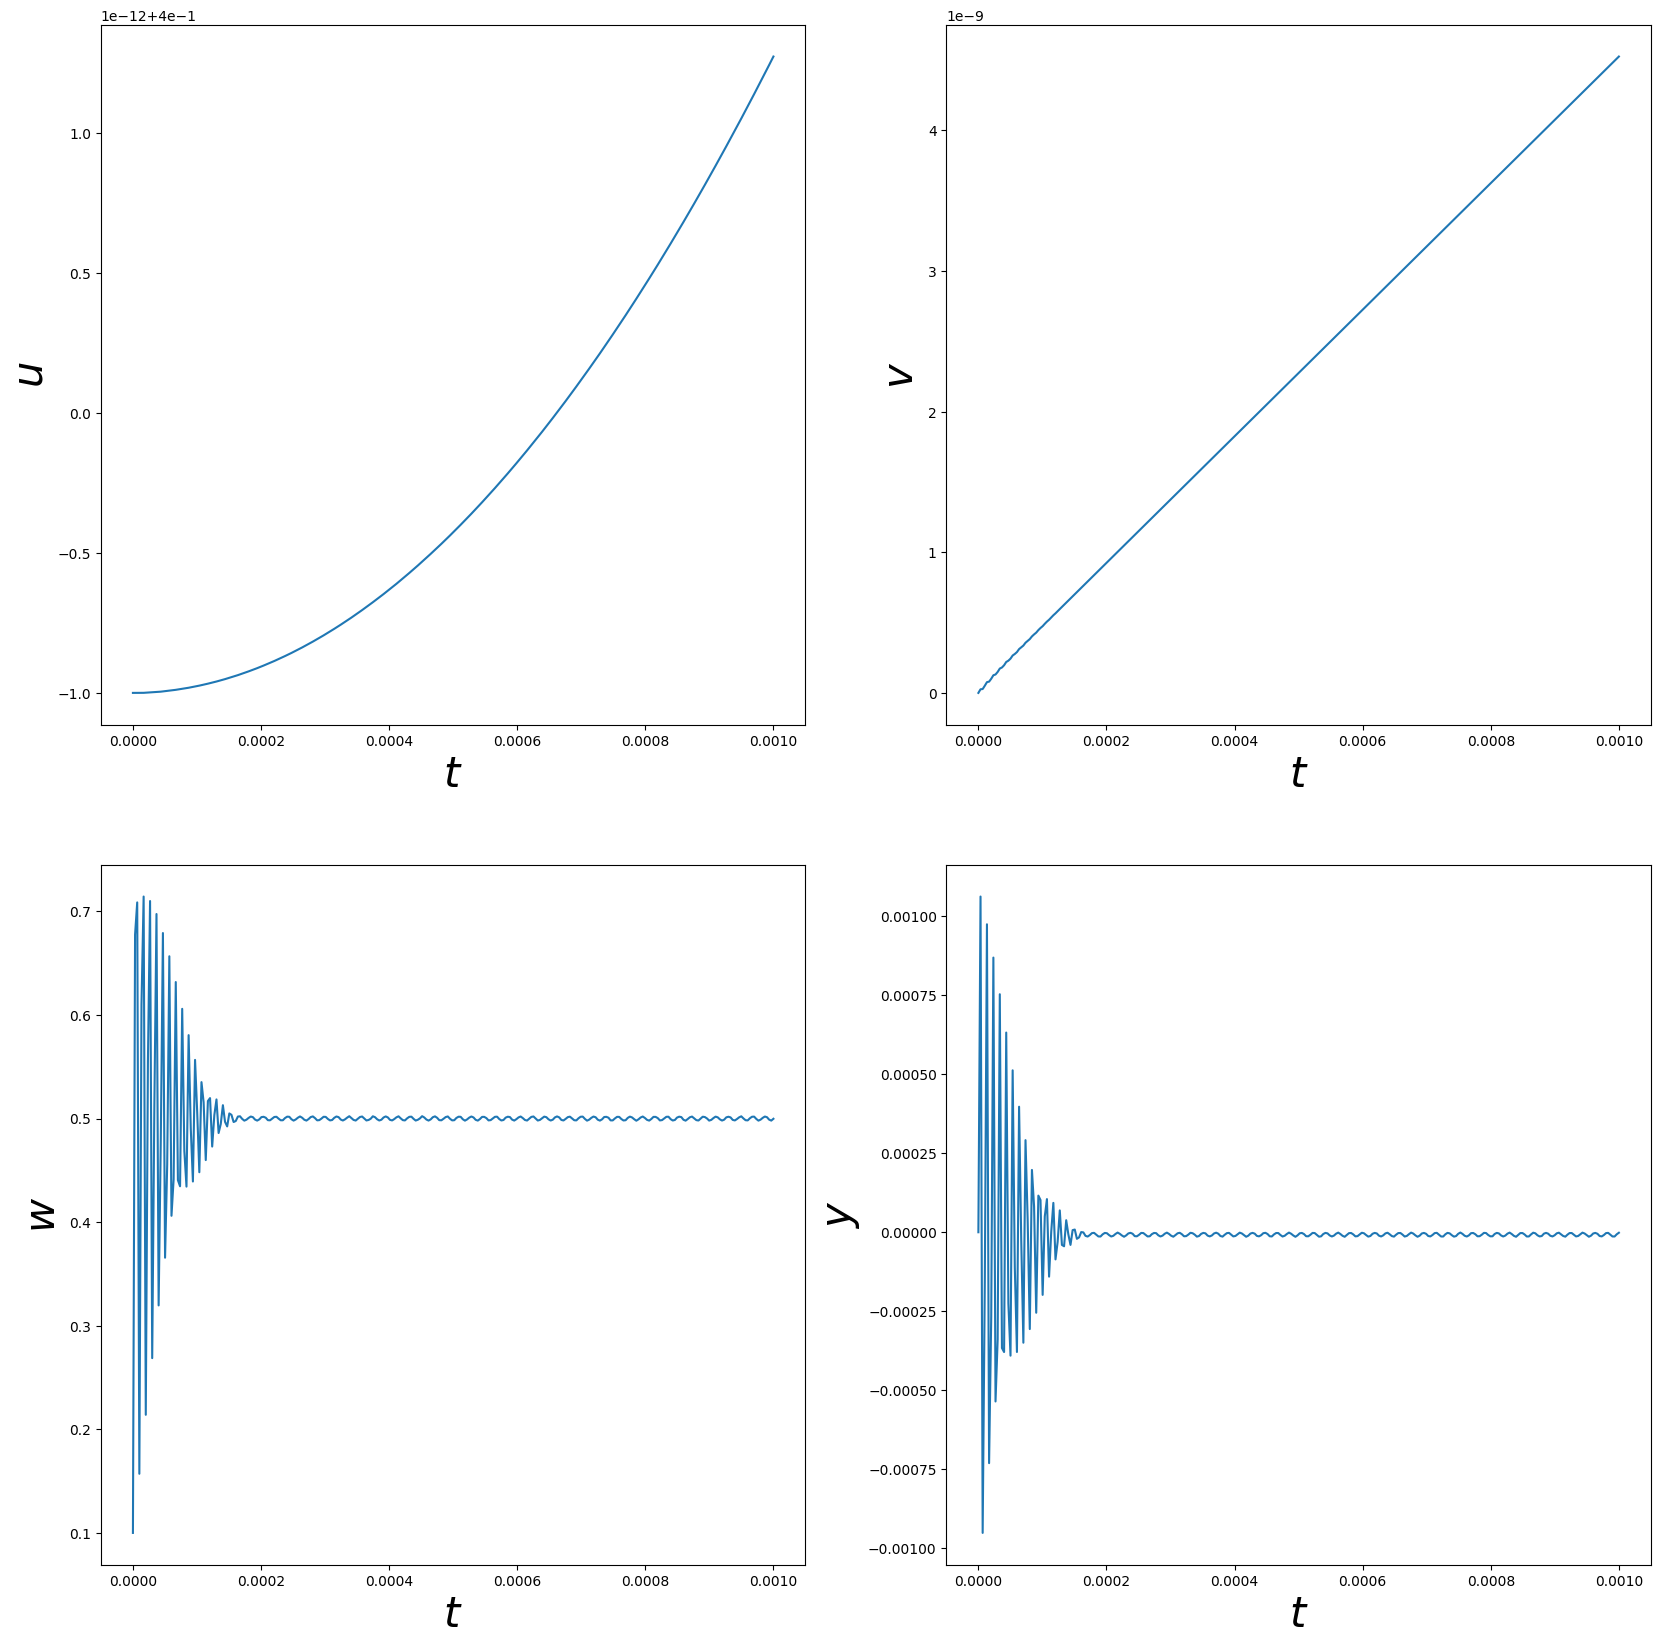

In [67]:
param_list=[w_L,beta_eq,r,eta]    
tf=1e-3               ### DO NOT increase this by a lot
u_0,v_0,w_0,y_0=4e-1,0,1e-1,0
psi_0=np.array([u_0,v_0,w_0,y_0])
label_list=["$u$","$v$","$w$","$y$"]

N_step=300
fig, axs = plt.subplots(2, 2,figsize=(20,20))
zz,t=evolve(psi_0,tf,param_list,N_step)
  
for i in range(4):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$t$',fontsize=30)

plt.show() 

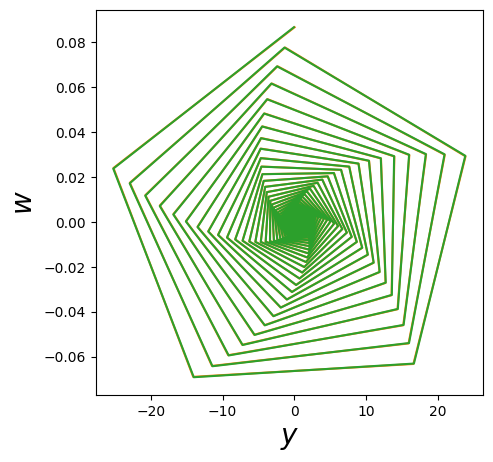

In [110]:
param_list=[w_L,beta_eq,r,eta]    
tf=1e-3               ### DO NOT increase this by a lot
u_0,v_0=2e-1,0
label_list=["$u$","$v$","$w$","$y$"]
N_step=500
fig, axs = plt.subplots(1, 1,figsize=(5,5))
theta_list=np.pi*np.linspace(0,1,3, endpoint=False)
#theta_list=np.pi*(1+1e-2*np.linspace(-1,1,2, endpoint=False))
#theta_list=np.pi*np.array([1])
for theta in theta_list:
    w_0=np.cos(theta)*1e-1
    y_0=np.sin(theta)*1e-1
    psi_0=np.array([u_0,v_0,w_0,y_0])
    zz,t=evolve(psi_0,tf,param_list,N_step)
  
    axs.plot(zz[2][:],zz[3][:])
    axs.set_ylabel("$w$",fontsize=20)
    axs.set_xlabel('$y$',fontsize=20)

plt.show() 

$\ddot{\varphi}+2(\eta-\frac{2}{\Omega}\frac{(1+r^2)(r+\varphi)}{[1+(r+\varphi)^2]^3})\dot{\varphi}+\frac{\varphi(\varphi+2r)}{1+(r+\varphi)^2}$

In [108]:
def ODE(t,z,ohm,r,eta,damp=1):
    phi,phi_d=z
    #phi_d_dot=1
    phi_d_dot=-2*damp*(eta-(2*(1+r**2)*(r+phi))/(ohm*(1+(r+phi)**2)**3))*phi_d-(phi*(phi+2*r))/(1+(r+phi)**2)
    phi_dot=phi_d
    return phi_dot,phi_d_dot
    
def evolve(psi_0,tf,param_list,N_step=100):
    t = np.linspace(0,tf,N_step)
    #xx=solve_ivp(ODE, [0,tf],psi_0,args=param_list,dense_output=True, t_eval=t,method="RK23")
    xx=solve_ivp(ODE, [0,tf],psi_0,args=param_list,dense_output=True, t_eval=t)
    zz=xx.sol(t)
    return zz,t

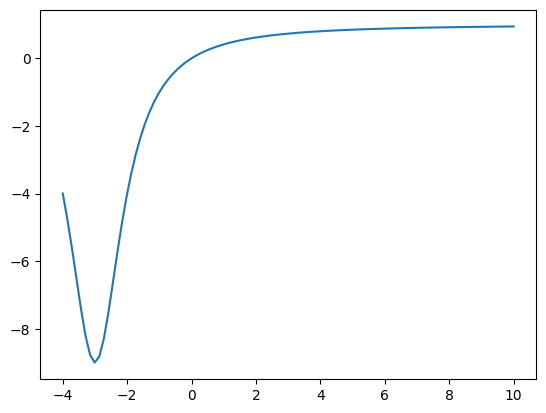

In [302]:
r=3
phi_0=np.linspace(-4,10,100)
E0=phi_0*(phi_0+2*r)/(1+(r+phi_0)**2)
plt.plot(phi_0,E0)
plt.show()

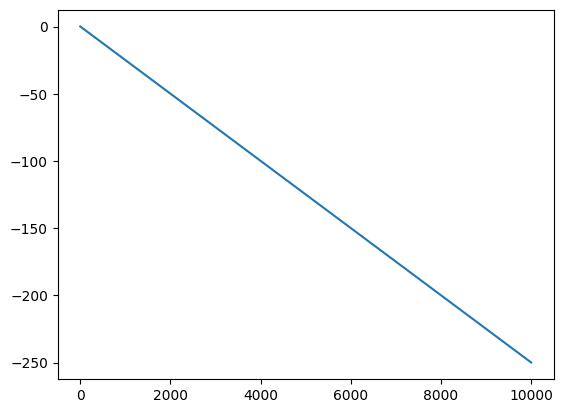

In [14]:
eta=20
phi_0=1e-3
t_list=10000*np.linspace(0,1,1000)
phi=((1-np.exp(-2*eta*t_list)/(2*eta)-t_list)/(2*eta))+phi_0
plt.plot(t_list,phi)
plt.show()

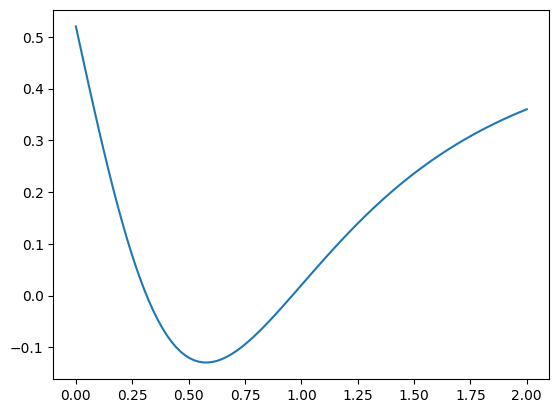

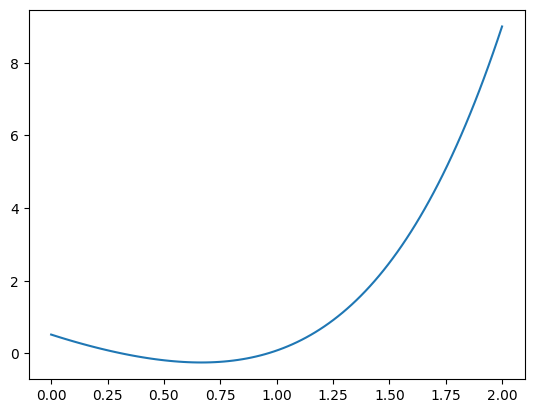

In [35]:
ohm=4
eta=0.13
r_list=np.linspace(0,2,100)
f=lambda r: (eta*ohm*(1+r**2)**2-2*r)/(1+r**2)**2
plt.plot(r_list,f(r_list))
plt.show()
f=lambda r: (eta*ohm*(1+r**2)**2-2*r)
plt.plot(r_list,f(r_list))
plt.show()

In [198]:
np.sign(0)

0

In [205]:
ohm=4
eta=0.01
eta_max=3**(1.5)/(ohm*8)


r_range=amplification_info(eta,ohm)
print(r_range)

<IPython.core.display.Latex object>

only one root found so trying bisection method
[0.02001603 3.49583907]


gamma_0_min= -0.15237976320958224
eta_max= 0.16237976320958225


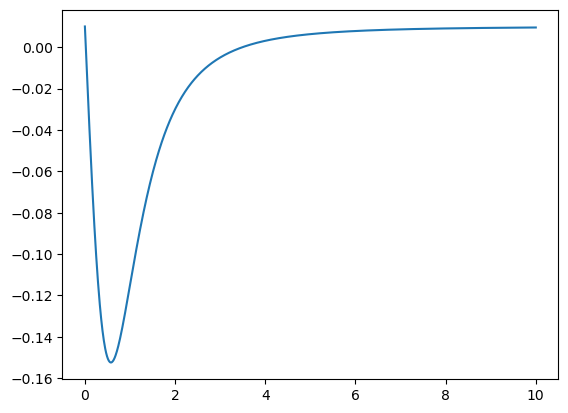

In [109]:
eta=0.01
ohm=4e0
r_list=np.linspace(0,10,1000)
def ret_gamma_0(r,eta,ohm):
    gamma_0=eta-2*r/(ohm*(1+r**2)**2)
    return gamma_0

def ret_gamm_0_d(r,eta,ohm):
    gamma_0_d=(2/ohm)*(1-3*r**2)/(1+r**2)**3
    return gamma_0_d
print("gamma_0_min=",eta-3**1.5/(8*ohm))
print("eta_max=",3**(1.5)/(ohm*8))
plt.plot(r_list,ret_gamma_0(r_list,eta,ohm))
plt.show()

In [121]:
ohm=4e0
r=0.7
eta_min=((1+r**2)/ohm)*(5/6)**2*(5**0.5/3)
print(eta_min)

0.09640455111327219


In [209]:
2*np.pi/8

0.7853981633974483

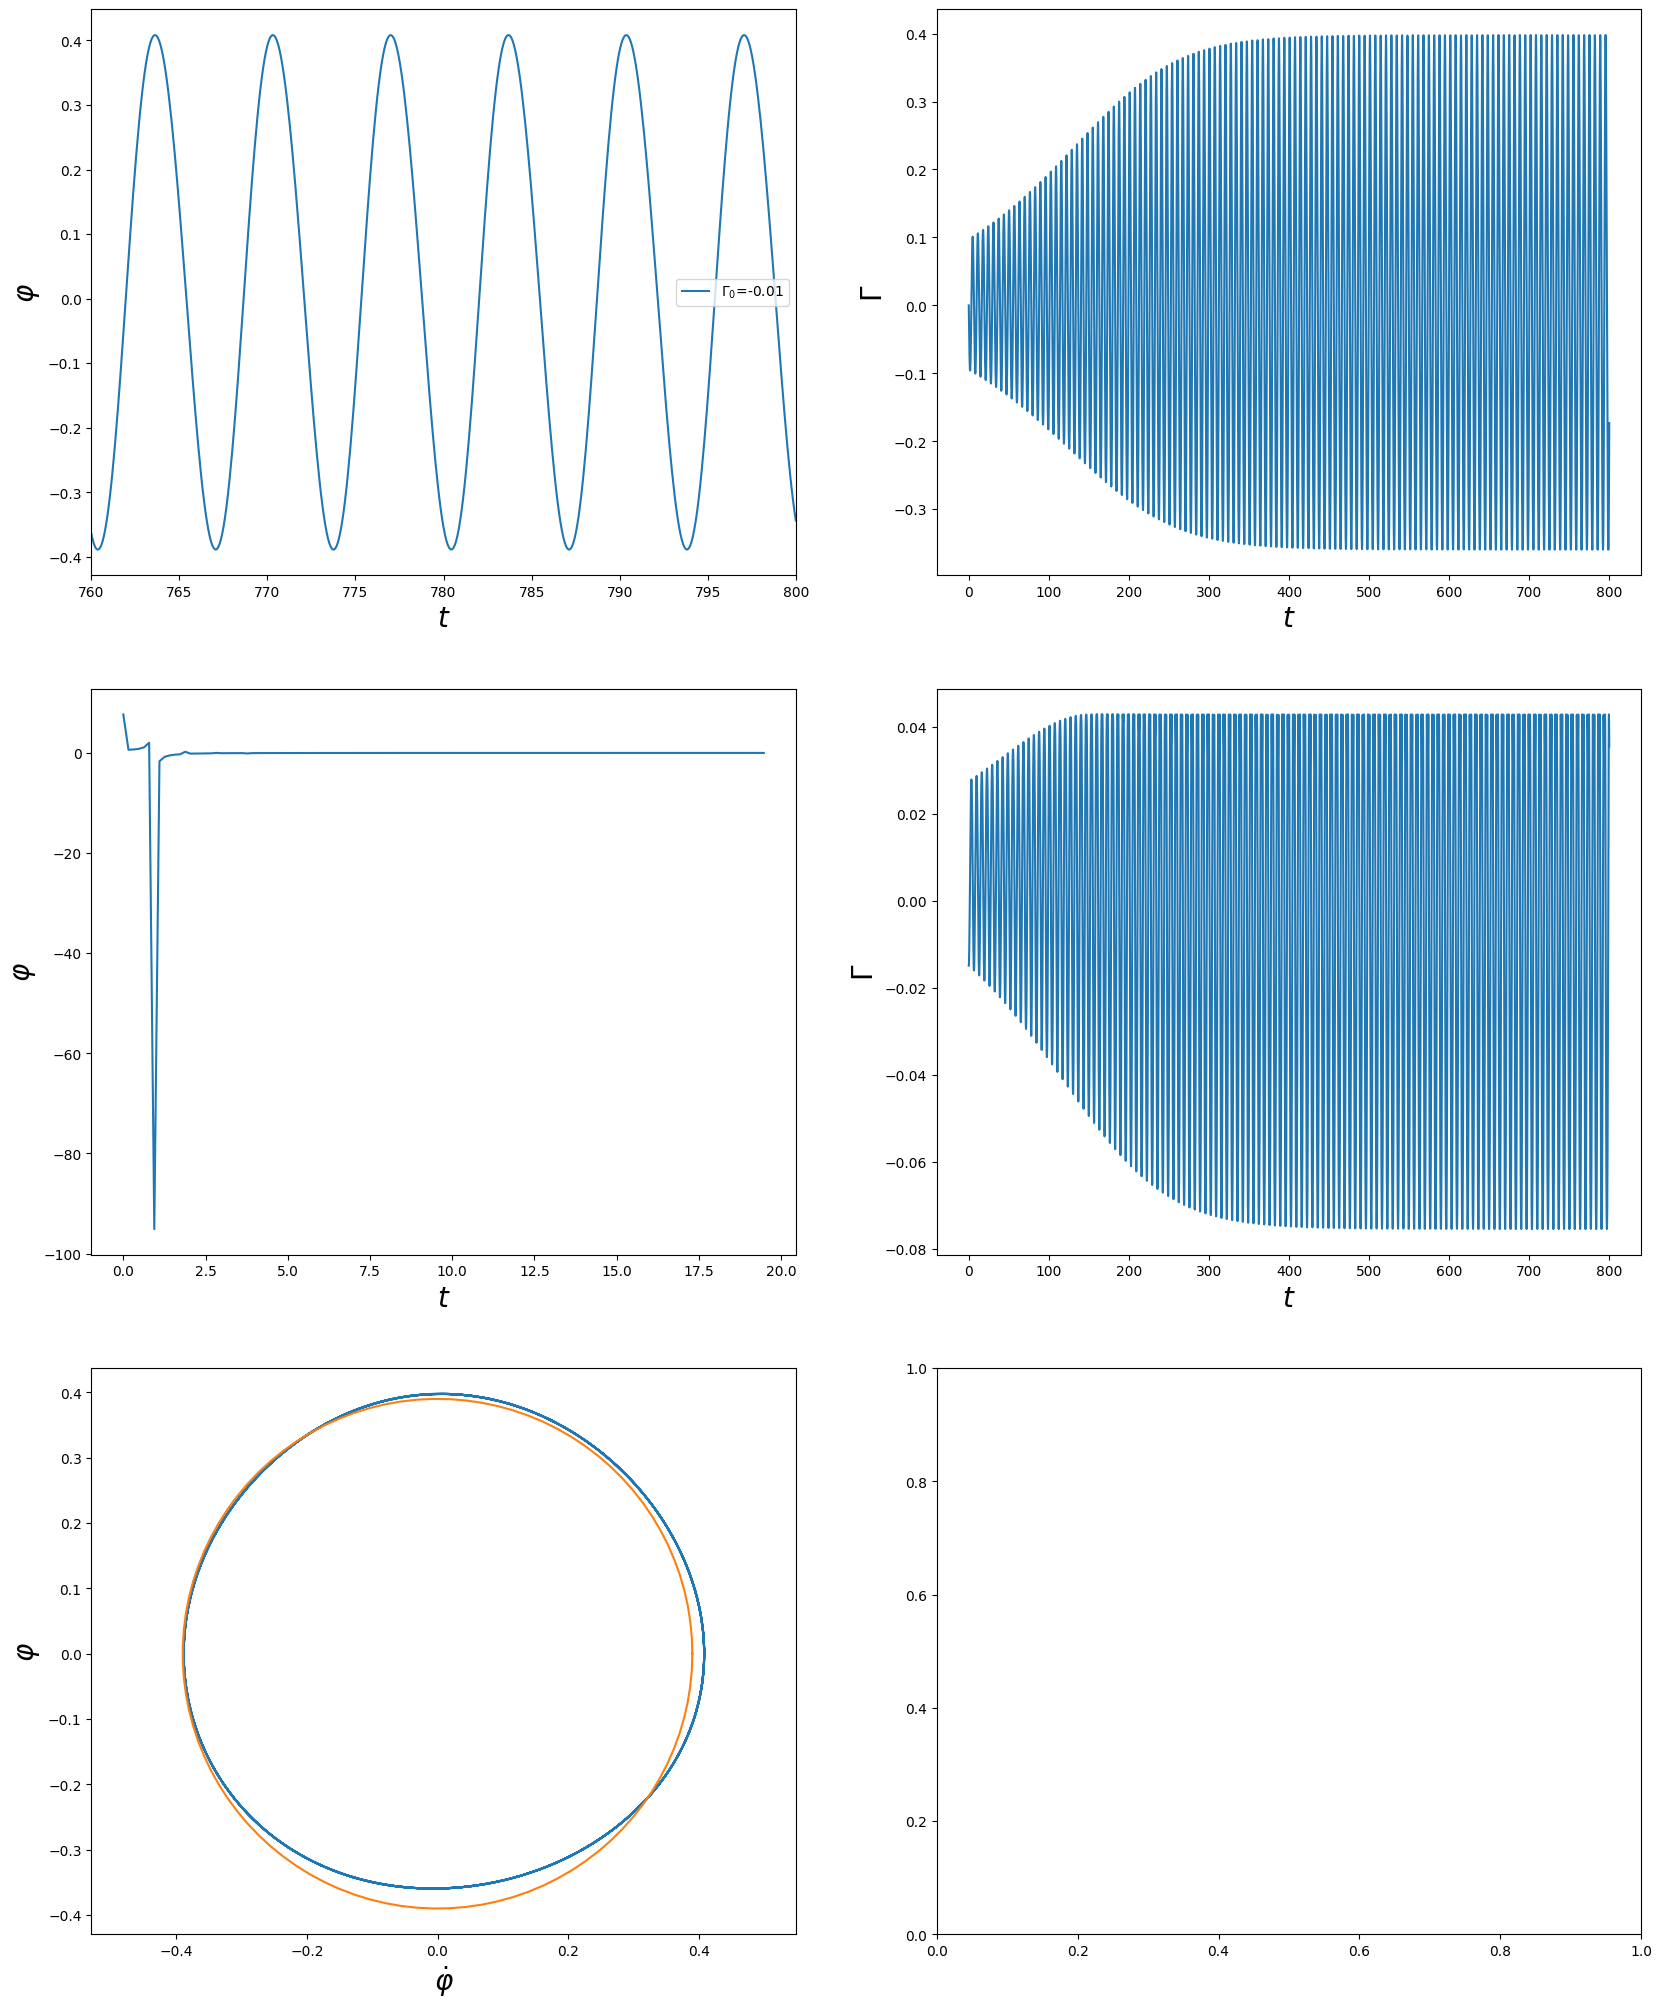

0.0


In [267]:
fig, axs = plt.subplots(3, 2,figsize=(20,25))

f_range=[int(0.95*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
axs[0,0].plot(t,zz[0],label="$\Gamma_0$={0}".format(np.round(gamma_0,2)))
# axs[0,0].set_ylim([-1e-3,1e-3])
axs[0,0].set_ylabel("$\\varphi$",fontsize=20)
axs[0,0].set_xlabel('$t$',fontsize=20)
axs[0,0].set_xlim(t_range)
axs[0,0].legend(loc='best')
# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

# axs[0,1].plot(t,-(eta-(2*(1+r**2)*(r+zz))/(ohm*(1+(r+zz)**2)**3)))

axs[0,1].plot(t,zz[1])
axs[0,1].set_ylabel("$\Gamma$",fontsize=20)
axs[0,1].set_xlabel('$t$',fontsize=20)

# param_list=[ohm,r,eta,0] 
# zz1,t=evolve(psi_0,tf,param_list,N_step)

# axs[1,0].plot(t,zz[0])
#f_range=[N_step//2,N_step]

omega_list=2*np.pi*np.arange((f_range[1]-f_range[0])//4)/(t_range[1]-t_range[0])
zz_f=np.fft.fft(zz[0][f_range[0]:f_range[1]])[:(f_range[1]-f_range[0])//4]

axs[1,0].plot(omega_list,zz_f)
# axs[1,0].set_xlim([100,200])
#axs[1,0].set_xlim([0,100])

axs[1,0].set_ylabel("$\\varphi$",fontsize=20)
axs[1,0].set_xlabel('$t$',fontsize=20)

# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

axs[1,1].plot(t,-(eta-(2*(1+r**2)*(r+zz[0]))/(ohm*(1+(r+zz[0])**2)**3)))
axs[1,1].set_ylabel("$\Gamma$",fontsize=20)
axs[1,1].set_xlabel('$t$',fontsize=20)

axs[2,0].plot(zz[0][f_range[0]:f_range[1]],zz[1][f_range[0]:f_range[1]])
x=np.linspace(0,2*np.pi,100)
r=0.4-0.01
axs[2,0].plot(r*np.cos(x),r*np.sin(x))
axs[2,0].set_ylabel("$\\varphi$",fontsize=20)
axs[2,0].set_xlabel('$\dot{\\varphi}$',fontsize=20)
axs[2,0].axis("equal")
plt.show() 

print(omega_list[np.argmax(zz_f)])

In [266]:
r=0.7
f=0.9032078879070655
D=(f**-4+4*r*f**-2-4)
print(D)
np.roots([1,(2*r-f**-2),(r**2+1-2*r*f**-2)])

0.9348988579317083


array([-0.57054387,  0.39635781])

In [179]:
(2*np.pi/7)

0.8975979010256552

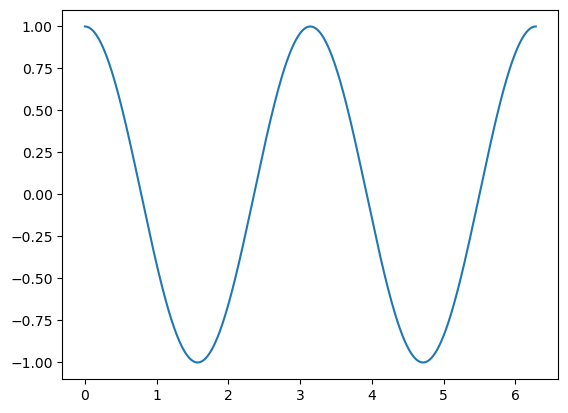

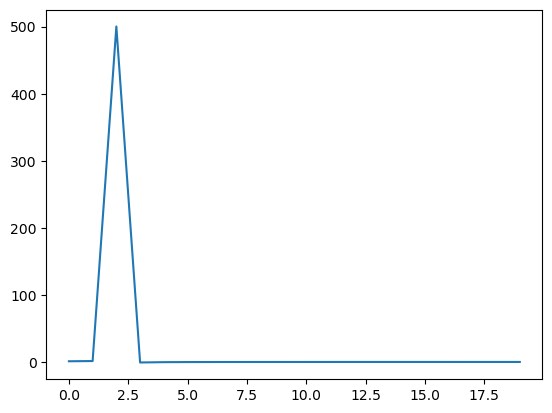

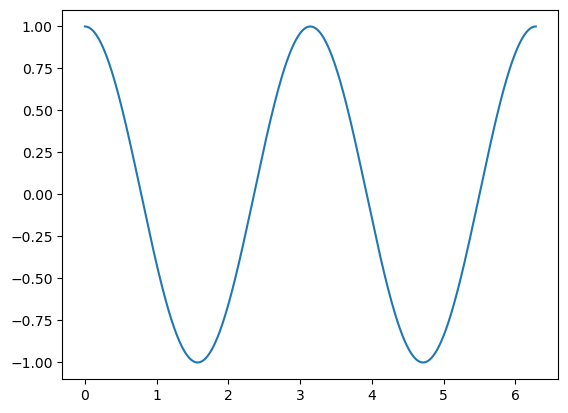

In [195]:
sr=1000
T=2*np.pi
# ts=tf/sr
# lam=pi
# f=2*pi/lam
fr=2
a=np.linspace(0,T,sr)
b=np.cos(fr*a)
c=np.fft.fft(b)
d=np.fft.ifft(c)
plt.plot(a,b)
plt.show()
plt.plot(2*np.pi*np.arange(20)/T,c[:20])
#plt.plot(c[:20])

plt.show()
plt.plot(a,d)
plt.show()

-0.010000000000000009


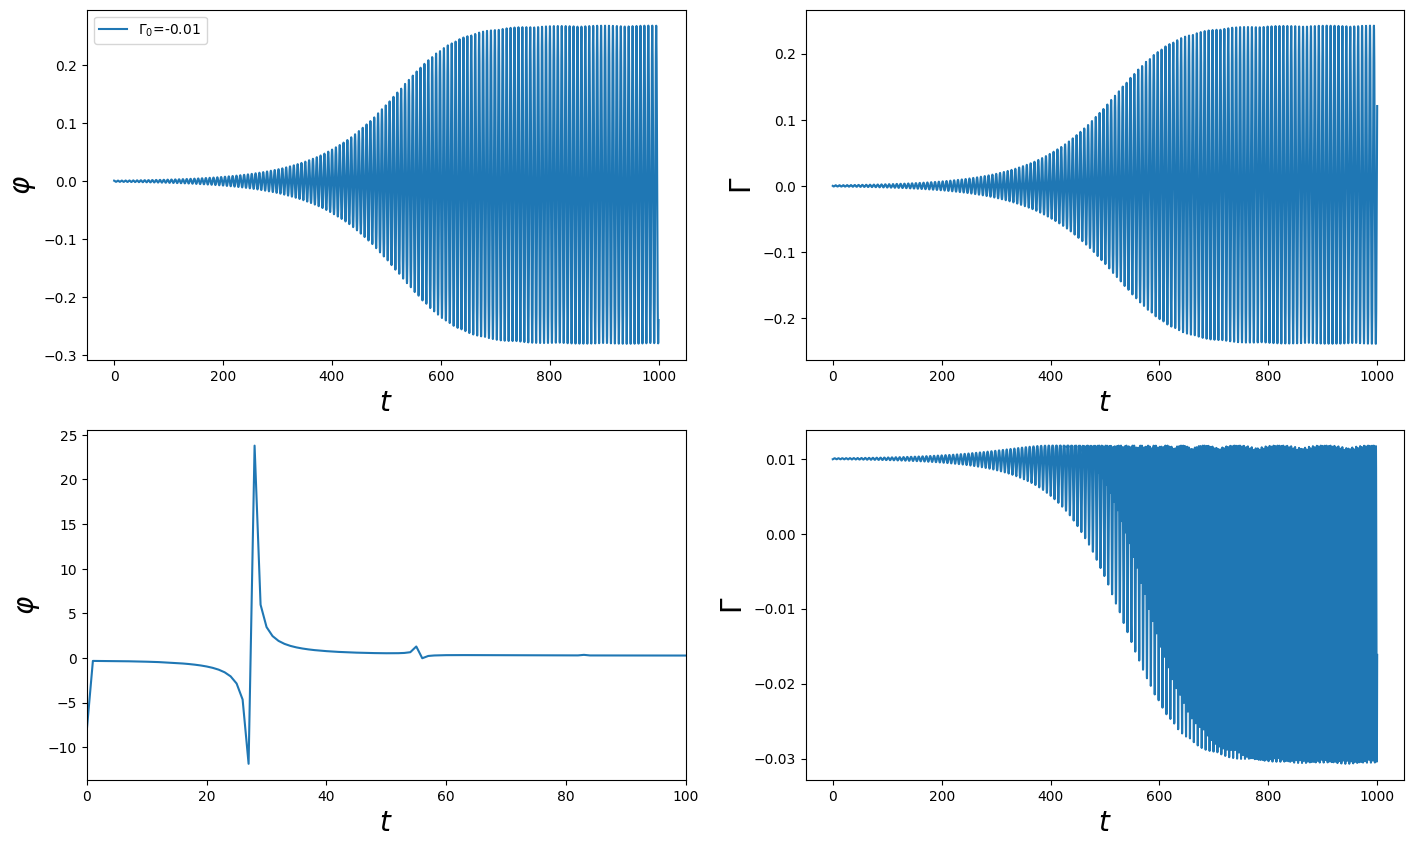

In [15]:
eta=0.15
ohm=4e0
r=0.5

gamma_0=eta-2*r/(ohm*(1+r**2)**2)
print(gamma_0)
   
tf=1e3              ### DO NOT increase this by a lot
phi_0,phi_d_0=1e-3,0
E0=phi_0*(phi_0+2*r)/(1+(r+phi_0)**2)
#print(E0)
psi_0=np.array([phi_0,phi_d_0])

N_step=1000*4
param_list=[ohm,r,eta,1] 
zz,t=evolve(psi_0,tf,param_list,N_step)
fig, axs = plt.subplots(2, 2,figsize=(17,10))

axs[0,0].plot(t,zz[0],label="$\Gamma_0$={0}".format(np.round(gamma_0,2)))
# axs[0,0].set_ylim([-1e-3,1e-3])
axs[0,0].set_ylabel("$\\varphi$",fontsize=20)
axs[0,0].set_xlabel('$t$',fontsize=20)
axs[0,0].legend(loc='best')
# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

# axs[0,1].plot(t,-(eta-(2*(1+r**2)*(r+zz))/(ohm*(1+(r+zz)**2)**3)))

axs[0,1].plot(t,zz[1])
axs[0,1].set_ylabel("$\Gamma$",fontsize=20)
axs[0,1].set_xlabel('$t$',fontsize=20)

param_list=[ohm,r,eta,0] 
zz1,t=evolve(psi_0,tf,param_list,N_step)

# axs[1,0].plot(t,zz[0])
f_range=[4*N_step//5,N_step]
omega_list=np.arange((f_range[1]-f_range[0])//2)

axs[1,0].plot(omega_list,np.fft.fft(zz[0][f_range[0]:f_range[1]])[:(f_range[1]-f_range[0])//2])
# axs[1,0].set_xlim([100,200])
axs[1,0].set_xlim([0,100])

axs[1,0].set_ylabel("$\\varphi$",fontsize=20)
axs[1,0].set_xlabel('$t$',fontsize=20)

# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

axs[1,1].plot(t,-(eta-(2*(1+r**2)*(r+zz[0]))/(ohm*(1+(r+zz[0])**2)**3)))
axs[1,1].set_ylabel("$\Gamma$",fontsize=20)
axs[1,1].set_xlabel('$t$',fontsize=20)

plt.show() 

In [2]:
np.arctan(3)

1.2490457723982544

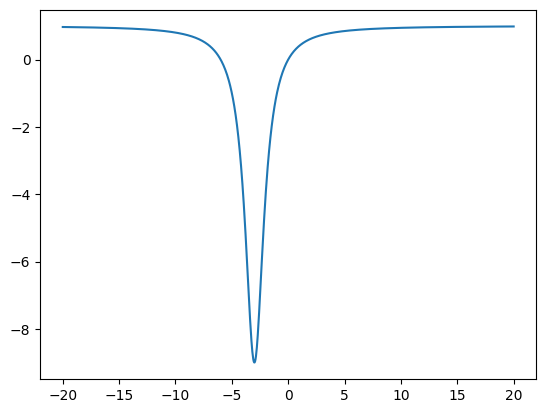

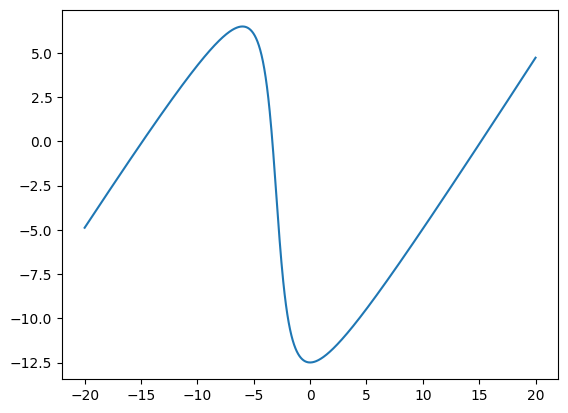

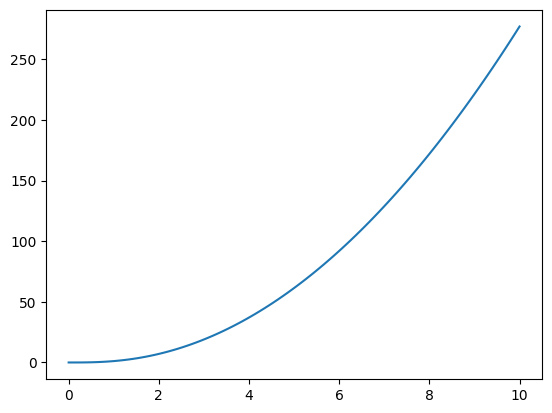

In [129]:
phi=np.linspace(-1,1,1000)*20
r=3
v_x=phi*(phi+2*r)/(1+(r+phi)**2)
plt.plot(phi,v_x)
plt.show()
#phi=np.linspace(-1,1,1000)*10

v=phi-(r**2+1)*np.arctan(r+phi)
plt.plot(phi,v)
plt.show()
r=np.linspace(0,10,100)
plt.plot(r,2*(r**2+1)*np.arctan(r)-2*r)
plt.show()

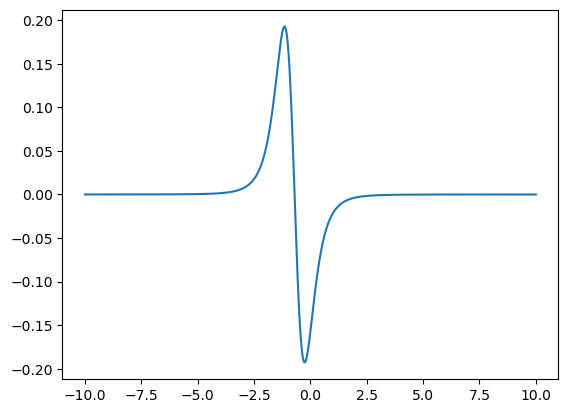

In [120]:
r=0.7
eta=0.1
ohm=4e0

def damp_term(phi,r,eta,ohm):
    gamma=eta*0-2*(1+r**2)*(r+phi)/(ohm*(1+(r+phi)**2)**3)
    return gamma

phi=np.linspace(-10,10,1000)
gamma=damp_term(phi,r,eta,ohm)
plt.plot(phi,gamma)
# plt.ylim(-0.1,0.1)
plt.show()

[-0.1014  0.1   ]
non-linear frequency= 1.8327812550728586
linear frequency= 0.8944271909999159


linear frequency 0.9693282805305133
-0.9099347787098433 4.690823007746925e-05
[-0.01  0.01]


2.1224716331258455

In [249]:
import matplotlib as mpl

cmap = plt.cm.viridis  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[(cmap.N-1)//2] = (1., 1., 1., 1.0)
cmaplist[(cmap.N+1)//2] = (1., 1., 1., 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
# bounds = np.linspace(0, 20, 21)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

<IPython.core.display.Latex object>

only one root found so trying bisection method
[0.21978973 1.20683863]


C:\Users\jhash\AppData\Local\Temp\ipykernel_1104\1489203504.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(E,A,r))[0]/(eta*ohm)
C:\Users\jhash\AppData\Local\Temp\ipykernel_1104\1489203504.py:19: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(E,A,r))[0]/(eta*ohm)
C:\Users\jhash\AppData\Local\Temp\ipykernel_1104\1489203504.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is

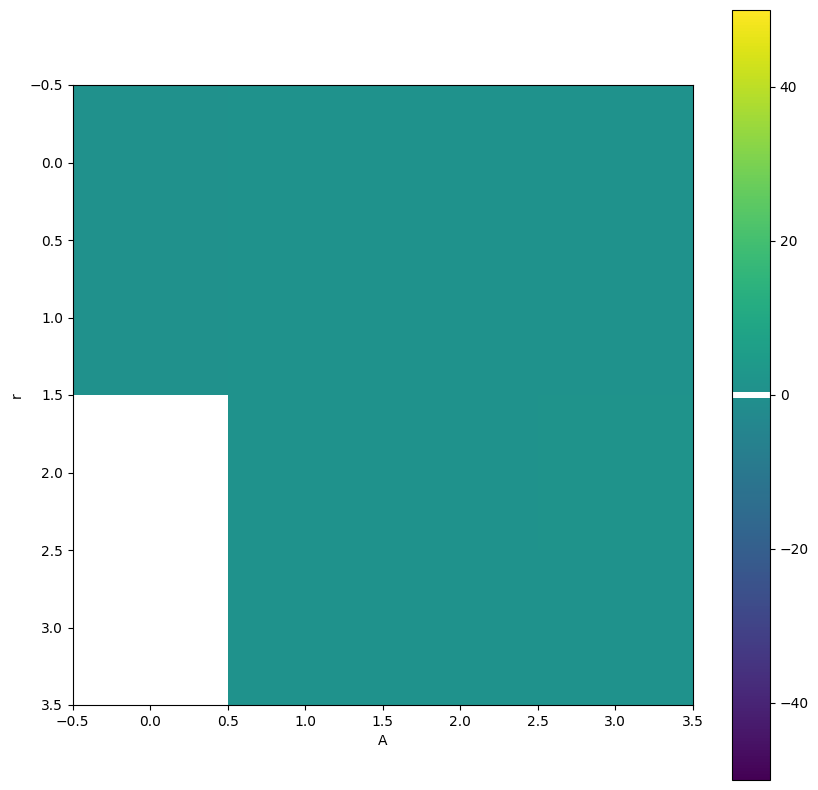

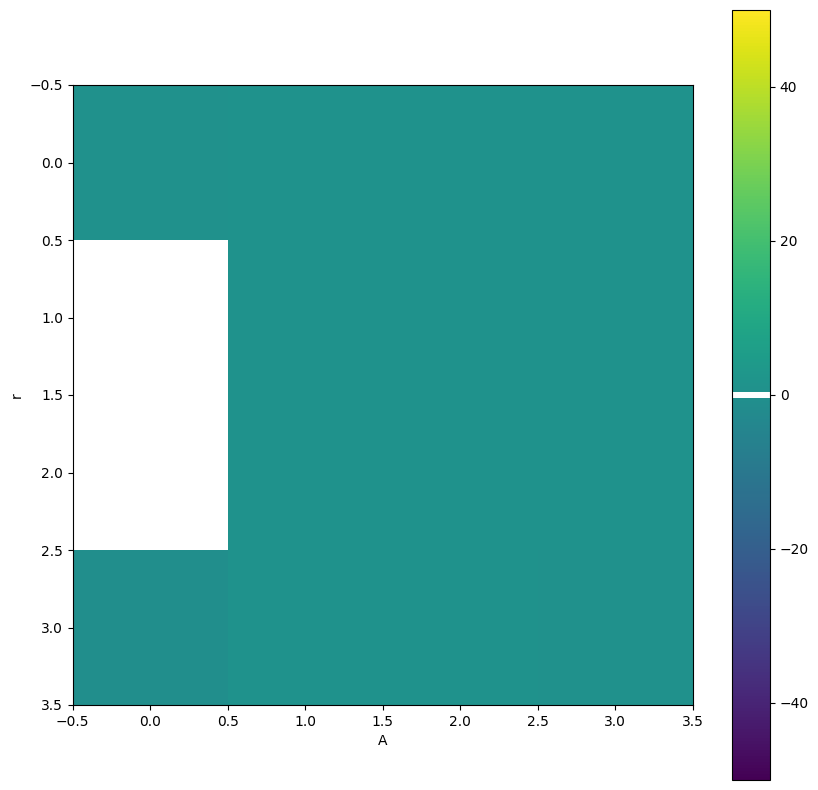

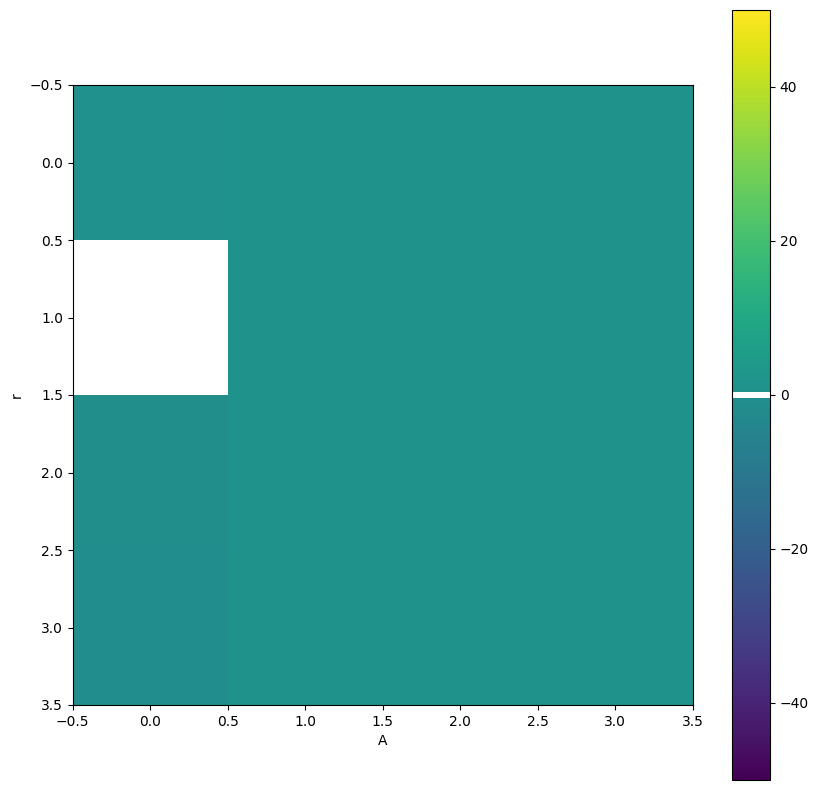

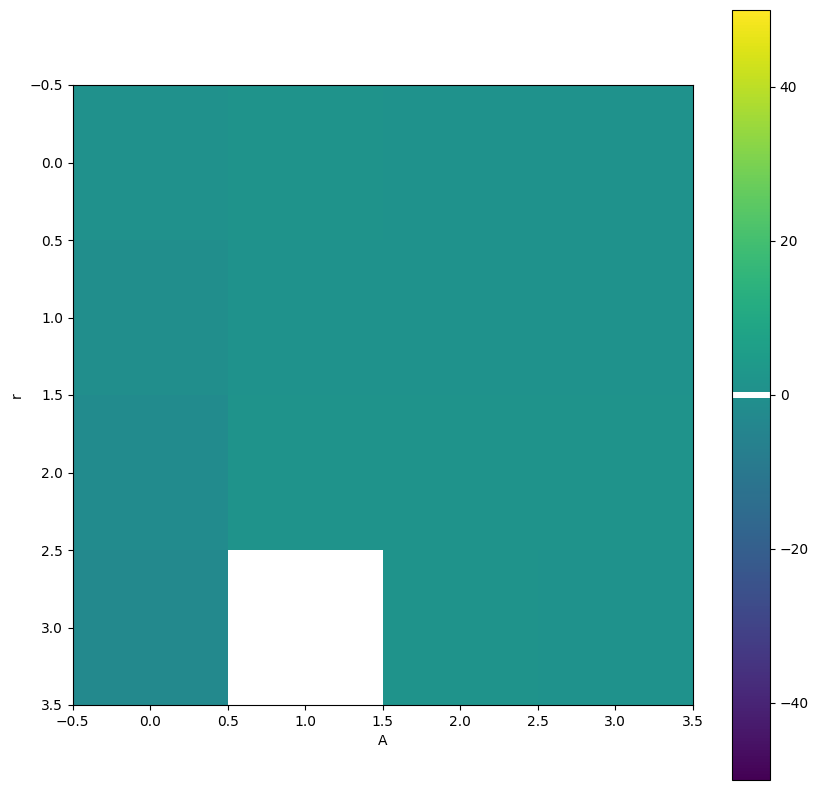

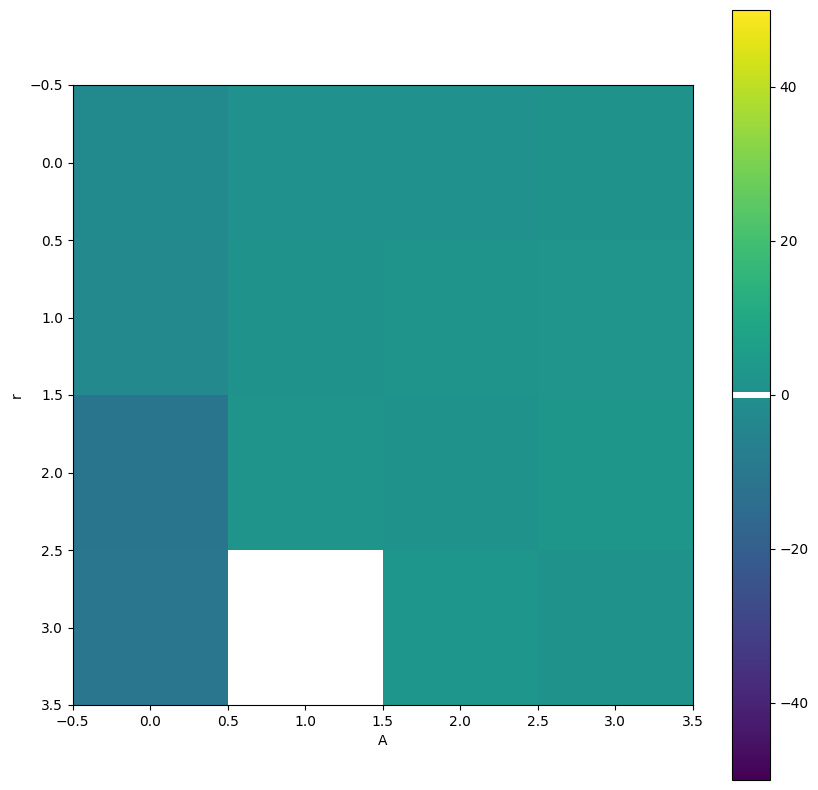

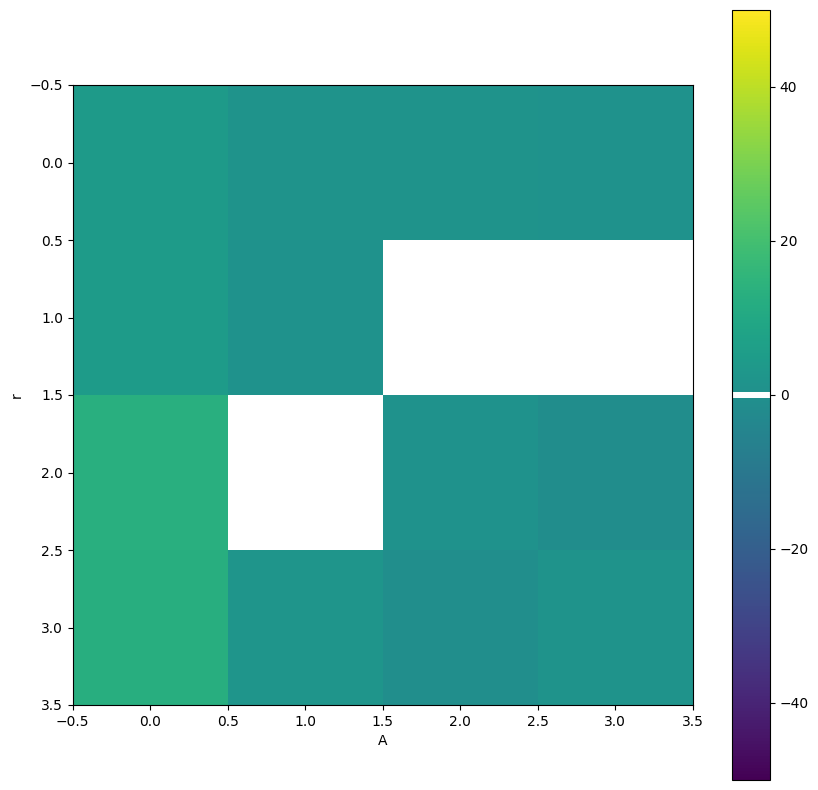

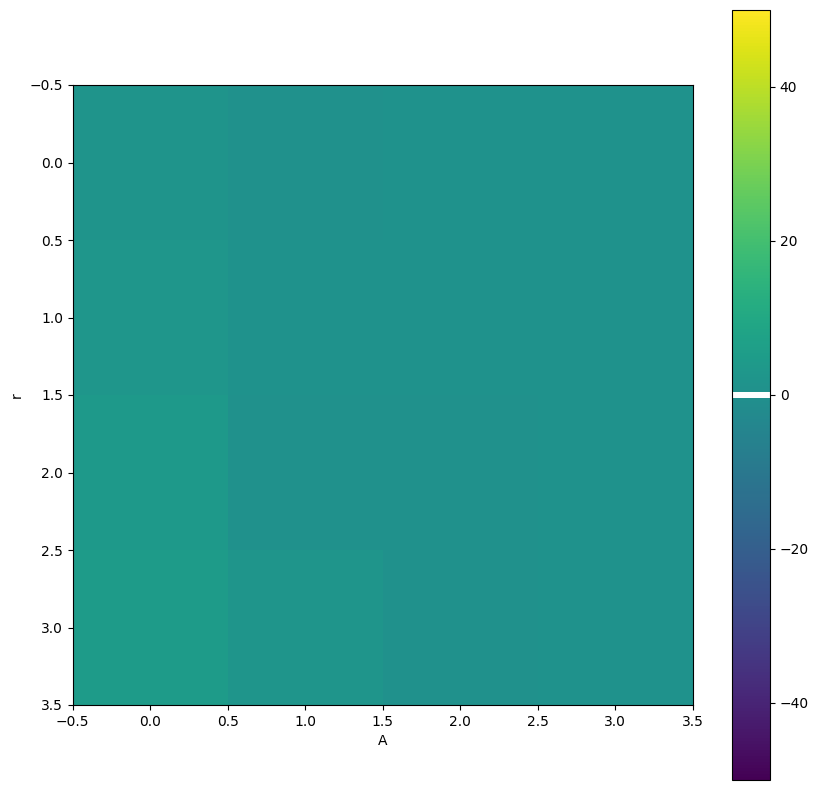

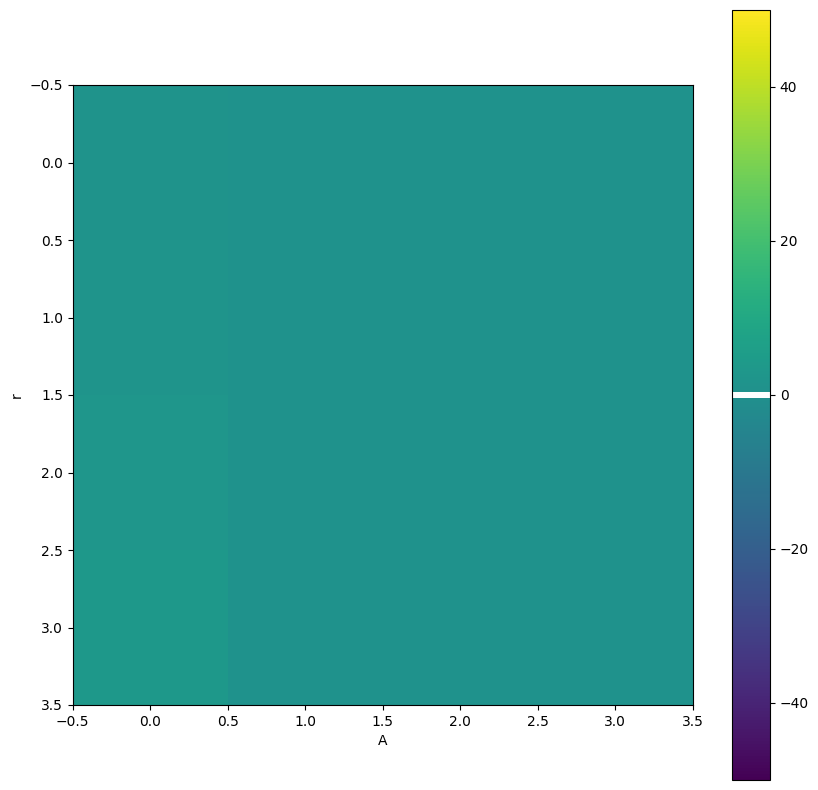

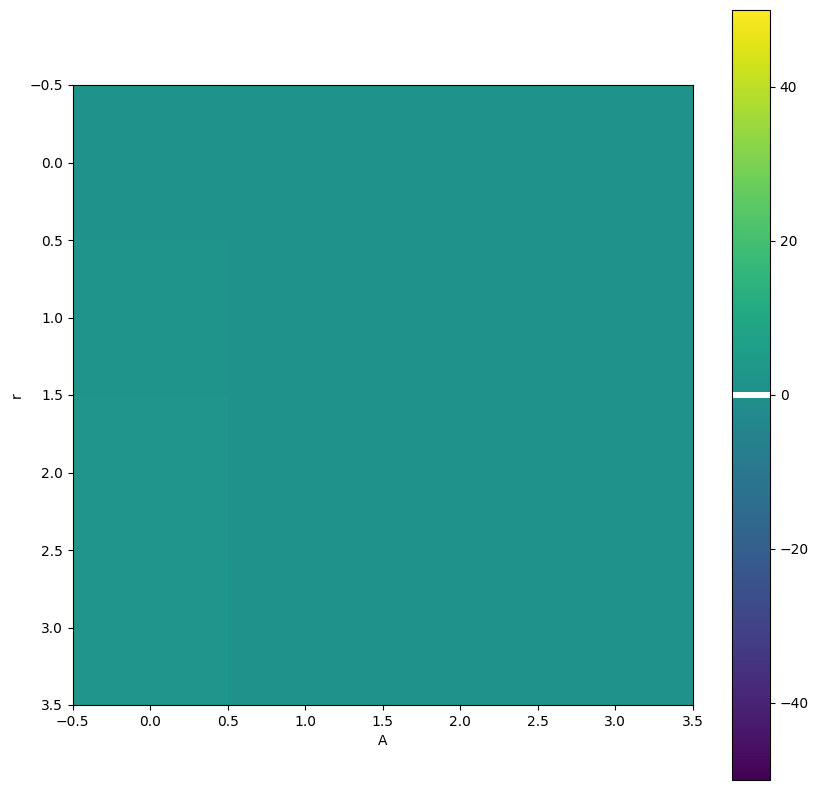

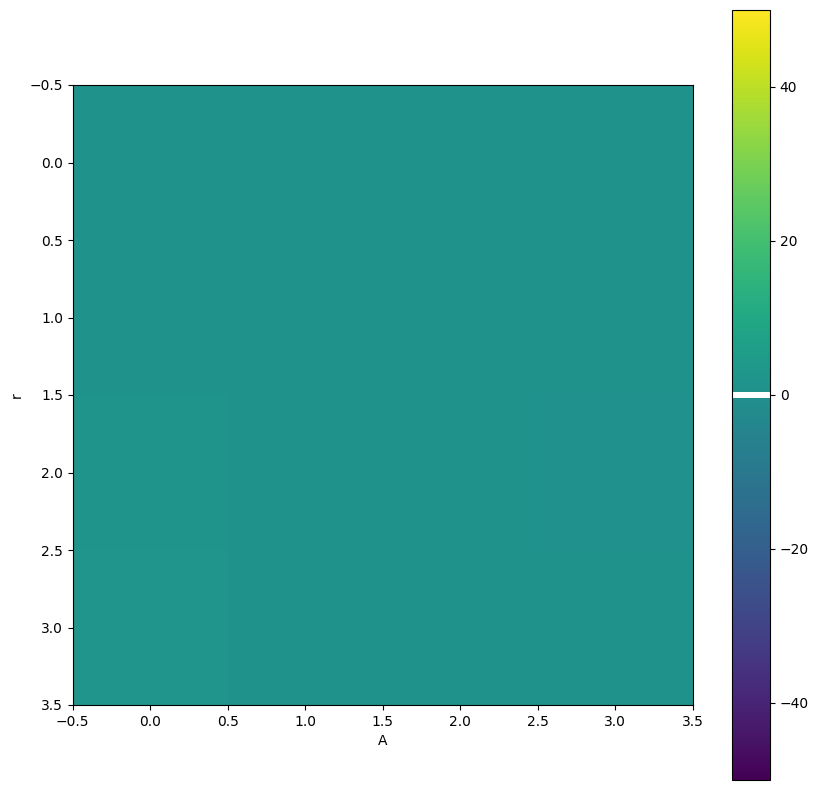

In [270]:
N_g=100
E=-1
eta=0.1
ohm=4e0
E_list=np.linspace(-1,1,10)
folder="C:/Users/jhash/OneDrive - City University of New York/Opto/Simulation/plots/"
r_range=amplification_info(eta,ohm)
print(r_range)
for E in E_list:
    r_list=np.linspace(r_range[0],r_range[1],N_g)
    A_list=20*np.linspace(0.1,1,N_g)
    eta_eff=np.zeros((N_g,N_g))
    for i, r in enumerate(r_list):
        #T=calc_T(V0,r,E)
        f=(2*r/(1+r**2))**0.5
        T=2*np.pi/f
        if T:
            for j,A in enumerate(A_list):
                eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(E,A,r))[0]/(eta*ohm)

    # plt.imshow(eta_eff,cmap='seismic')
    # plt.colorbar()
    # plt.show()
    if np.trace(eta_eff)>0:
        plt.figure(figsize=(10,10))
        plt.imshow(eta_eff,cmap=cmap,vmin=-50,vmax=50)
        plt.colorbar()
        plt.xlabel("A")
        #plt.xticks(A_list)
        plt.ylabel("r")
        #plt.yticks(r_list)
        file="damping_E={0}_eta={1}_ohm={2}.jpg".format(np.round(E,2),eta,ohm)
        #plt.savefig("C:/Users/jhash/Documents/renders/damping_E={0}_eta={1}_ohm={2}.jpg".format(E,eta,ohm))
        plt.savefig(folder+file)
        #plt.show()

C:\Users\jhash\AppData\Local\Temp\ipykernel_13400\1019685282.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  eta_eff[i,j]=1-quad(damp_coeff,0,2*np.pi/omega,args=(A,r))[0]/(eta*ohm*np.pi)
C:\Users\jhash\AppData\Local\Temp\ipykernel_13400\1019685282.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  eta_eff[i,j]=1-quad(damp_coeff,0,2*np.pi/omega,args=(A,r))[0]/(eta*ohm*np.pi)


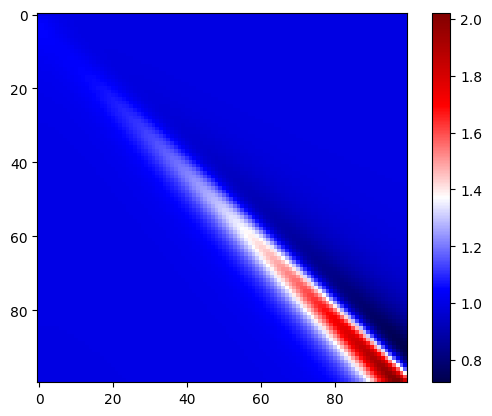

In [41]:
N_g=100
#omega=1

r_list=10*np.linspace(0,1,N_g)
A_list=10*np.linspace(0,1,N_g)
eta_eff=np.zeros((N_g,N_g))
for i, r in enumerate(r_list):
    for j,A in enumerate(A_list):
        omega=(r/(1+r**2))**0.5
        T=2*np.pi/omega
        eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(A,r))[0]/(eta*ohm*T)
        
plt.imshow(eta_eff,cmap='seismic')
plt.colorbar()
plt.show()

C:\Users\jhash\AppData\Local\Temp\ipykernel_13400\2994802689.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  eta_eff[i,j]=1-quad(damp_coeff,0,2*np.pi/omega,args=(A,r))[0]
C:\Users\jhash\AppData\Local\Temp\ipykernel_13400\2994802689.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  eta_eff[i,j]=1-quad(damp_coeff,0,2*np.pi/omega,args=(A,r))[0]


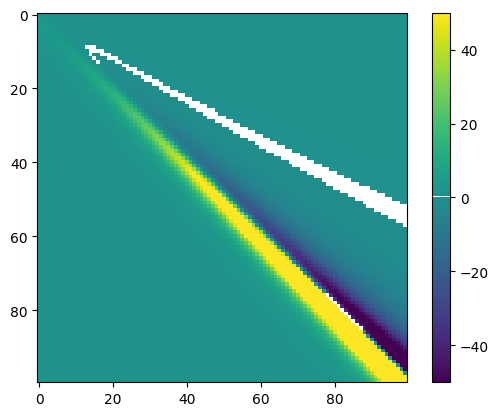

In [48]:
N_g=100
r_list=20*np.linspace(0,1,N_g)
A_list=20*np.linspace(0,1,N_g)
eta_eff=np.zeros((N_g,N_g))
for i, r in enumerate(r_list):
    for j,A in enumerate(A_list):
        omega=(r/(1+r**2))**0.5
        eta_eff[i,j]=1-quad(damp_coeff,0,2*np.pi/omega,args=(A,r))[0]
        
plt.imshow(eta_eff,cmap=cmap,vmin=-50,vmax=50)
plt.colorbar()
plt.show()

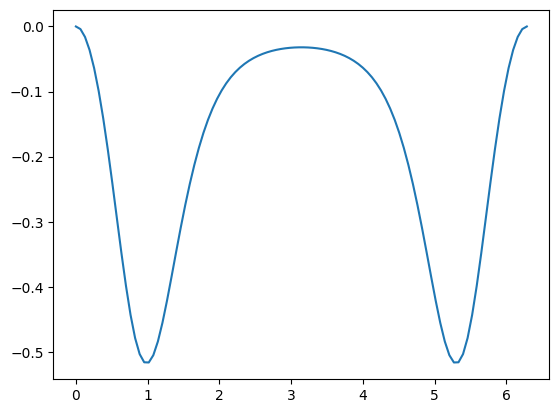

In [69]:
x=np.linspace(0,2*np.pi,100)
y=damp_coeff(x,1,1)
plt.plot(x,y)